# Análisis Comparativo de Modelos SVM y CNN para Clasificación de Imágenes con Explicabilidad mediante Grad-CAM

- Integrantes: Felipe Peralta, Samantha Suquilanda

In [3]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import tensorflow as tf
import cv2
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

## Rutas del dataset y selección de clases

In [4]:
base_dir = '../data/fruits-360_100x100/fruits-360'
train_dir = os.path.join(base_dir, 'Training')
test_dir = os.path.join(base_dir, 'Test')

classes_to_use = ['Apple Red 1', 'Banana 1', 'Limes 1', 'Strawberry 1', 'Cherimoya 1', 'Cucumber 1', 'Ginger 2', 'Mango 1', 'Nut 1', 'Peach 1', 'Papaya 1', 'Orange 1']
print(f"Clases seleccionadas: {classes_to_use}")

Clases seleccionadas: ['Apple Red 1', 'Banana 1', 'Limes 1', 'Strawberry 1', 'Cherimoya 1', 'Cucumber 1', 'Ginger 2', 'Mango 1', 'Nut 1', 'Peach 1', 'Papaya 1', 'Orange 1']


## Normalización

In [5]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

## Cargar los datos de entrenamiento y validación

In [6]:
# Cargar entrenamiento
print("Cargando imágenes de entrenamiento...")
train_generator = datagen.flow_from_directory(
    train_dir,                  
    target_size=(100, 100),     
    batch_size=32,              
    class_mode='categorical', 
    subset='training',          # Pedir la parte de entrenamiento
    classes=classes_to_use,     
    shuffle=True                
)

# Cargar validación
print("Cargando imágenes de validación...")
val_generator = datagen.flow_from_directory(
    train_dir,                
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    subset='validation',        # Pedir la parte reservada para validar
    classes=classes_to_use,
    shuffle=True
)

Cargando imágenes de entrenamiento...
Found 4576 images belonging to 12 classes.
Cargando imágenes de validación...
Found 1140 images belonging to 12 classes.


## Verificación visual

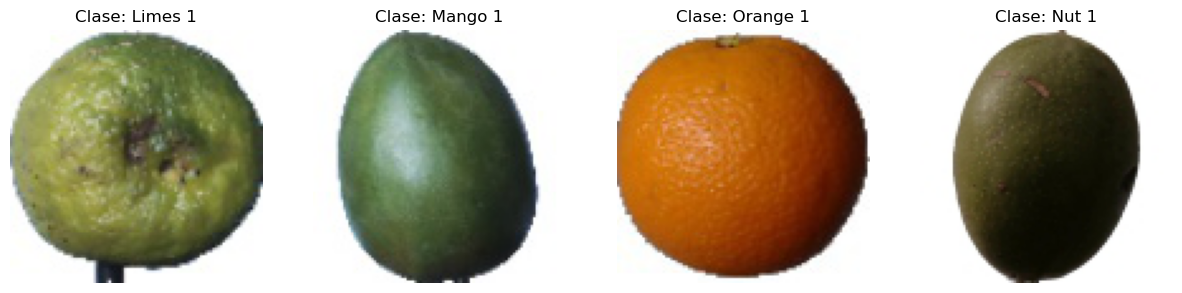

In [7]:
train_generator.reset()
x_batch, y_batch = train_generator[0]
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    axes[i].imshow(x_batch[i])
    class_idx = np.argmax(y_batch[i])
    class_name = list(train_generator.class_indices.keys())[class_idx]
    axes[i].set_title(f"Clase: {class_name}")
    axes[i].axis('off')
plt.show()

## SVM

### Convertir datos para SVM

In [8]:
def get_data_from_generator(generator):
    generator.reset()
    X_data, y_data = [], []
    
    for i in range(len(generator)):
        X_batch, y_batch = generator[i]
        X_data.append(X_batch)
        y_data.append(y_batch)
        
    return np.concatenate(X_data), np.concatenate(y_data)

In [9]:
print("Convirtiendo datos para SVM...")
X_train, y_train_cat = get_data_from_generator(train_generator)
X_test, y_test_cat = get_data_from_generator(val_generator)

num_pixels = 100 * 100 * 3
X_train_flat = X_train.reshape(X_train.shape[0], num_pixels)
X_test_flat = X_test.reshape(X_test.shape[0], num_pixels)

y_train_indices = np.argmax(y_train_cat, axis=1)
y_test_indices = np.argmax(y_test_cat, axis=1)

print(f"Dimensiones para SVM: {X_train_flat.shape}")
print(f"Clases únicas en entrenamiento: {np.unique(y_train_indices)}")
print(f"Distribución de clases en train: {np.bincount(y_train_indices)}")
print(f"Clases únicas en test: {np.unique(y_test_indices)}")
print(f"Distribución de clases en test: {np.bincount(y_test_indices)}")

Convirtiendo datos para SVM...
Dimensiones para SVM: (4576, 30000)
Clases únicas en entrenamiento: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Distribución de clases en train: [394 392 392 394 778 120 349 392 193 394 394 384]
Clases únicas en test: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Distribución de clases en test: [ 98  98  98  98 194  30  87  98  48  98  98  95]


### Entrenamiento y evaluación del modelo SVM

In [10]:
print("Entrenando SVM...")

# Crear el modelo SVM
svm_model = SVC(kernel='linear', probability=True, random_state=42)

# Entrenar
svm_model.fit(X_train_flat, y_train_indices)

Entrenando SVM...


,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [11]:
# Evaluar
y_pred_svm = svm_model.predict(X_test_flat)
print("--- Resultados SVM ---")
print(f"Accuracy: {accuracy_score(y_test_indices, y_pred_svm):.2f}")
print(classification_report(y_test_indices, y_pred_svm, target_names=classes_to_use))

--- Resultados SVM ---
Accuracy: 1.00
              precision    recall  f1-score   support

 Apple Red 1       1.00      1.00      1.00        98
    Banana 1       1.00      0.96      0.98        98
     Limes 1       1.00      1.00      1.00        98
Strawberry 1       1.00      1.00      1.00        98
 Cherimoya 1       1.00      1.00      1.00       194
  Cucumber 1       1.00      1.00      1.00        30
    Ginger 2       0.96      1.00      0.98        87
     Mango 1       1.00      1.00      1.00        98
       Nut 1       1.00      1.00      1.00        48
     Peach 1       1.00      1.00      1.00        98
    Papaya 1       1.00      1.00      1.00        98
    Orange 1       1.00      1.00      1.00        95

    accuracy                           1.00      1140
   macro avg       1.00      1.00      1.00      1140
weighted avg       1.00      1.00      1.00      1140



## Análisis de Explicabilidad (XAI) con Grad-CAM en SVM

In [18]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Guardar la activación original de la última capa
    last_layer = model.layers[-1]
    original_activation = last_layer.activation
    
    # Cambiar la activación a lineal para obtener los "logits"
    last_layer.activation = tf.keras.activations.linear
    
    # Construir el modelo de gradiente con la activación lineal
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Grabar el gradiente
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Calcular el gradiente
    grads = tape.gradient(class_channel, last_conv_layer_output)
    
    # Global Average Pooling
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiplicar canales por importancia
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Restaurar la activación original del modelo
    last_layer.activation = original_activation

    # Normalización y limpieza
    heatmap = tf.maximum(heatmap, 0)
    max_heat = tf.math.reduce_max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat

    return heatmap.numpy()

In [19]:
def predecir_y_explicar(ruta_imagen, model, classes):
    img = tf.keras.preprocessing.image.load_img(ruta_imagen, target_size=(100, 100))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    preds = model.predict(img_array)
    idx_pred = np.argmax(preds[0])
    label_pred = classes[idx_pred]
    confianza = preds[0][idx_pred]

    print(f"Predicción: {label_pred} ({confianza*100:.2f}%)")

    # Generar el heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer)

    # Visualización
    heatmap_resized = cv2.resize(heatmap, (100, 100))
    heatmap_colored = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_colored, cv2.COLORMAP_JET)
    
    img_original_uint8 = np.uint8(255 * img_array[0])
    
    # Superposición
    superimposed_img = cv2.addWeighted(img_original_uint8, 0.6, heatmap_colored, 0.4, 0)

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(img_array[0])
    ax[0].set_title("Imagen Original")
    
    # Mostrar el heatmap
    ax[1].imshow(heatmap, cmap='jet')
    ax[1].set_title("Activación (Raw)")
    
    ax[2].imshow(superimposed_img)
    ax[2].set_title(f"Explicación: {label_pred}")
    plt.show()

In [20]:
def get_last_conv_layer_name(model):
    # Buscar la última capa convolucional para conectar el Grad-CAM
    for layer in reversed(model.layers):
        if 'conv' in layer.name:
            return layer.name
    raise ValueError("No se encontró capa convolucional")

last_conv_layer = get_last_conv_layer_name(cnn_model)
print(f"Capa Convolucional detectada para análisis: {last_conv_layer}")

Capa Convolucional detectada para análisis: conv2d_2


## Ejecución de casos de prueba

Caso 1: Banana
1/1 [==============================] - 0s 26ms/step
Predicción: Banana 1 (100.00%)


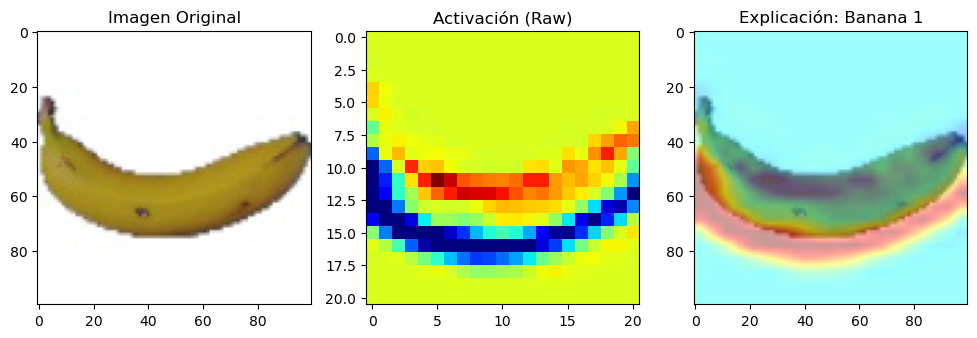

In [21]:
# CASO 1: Banana
print("Caso 1: Banana")
ruta_caso1 = "./data/fruits-360_100x100/fruits-360/Test/Banana 1/100_100.jpg"
if not os.path.exists(ruta_caso1):
    print(f"No se encontró la imagen en {ruta_caso1}")
else:
    predecir_y_explicar(ruta_caso1, cnn_model, classes_to_use)

Caso 2: Fresa
1/1 [==============================] - 0s 22ms/step
Predicción: Strawberry 1 (100.00%)


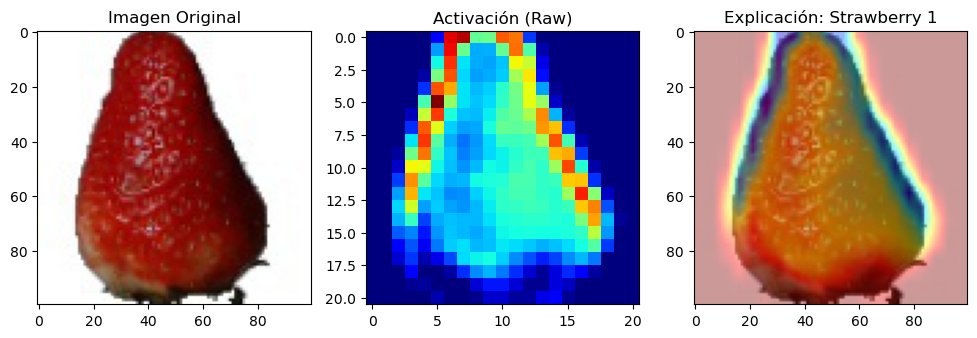

In [22]:
# CASO 2: Fresa
print("Caso 2: Fresa")
ruta_caso2 = "./data/fruits-360_100x100/fruits-360/Test/Strawberry 1/45_100.jpg"
if not os.path.exists(ruta_caso2):
    print(f"No se encontró la imagen en {ruta_caso2}")
else:
    predecir_y_explicar(ruta_caso2, cnn_model, classes_to_use)